<a href="https://colab.research.google.com/github/honeygupta66/skills-introduction-to-github/blob/main/CNN_Model_FMNIST_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Neural Network Architectures — CNN (Images)

This notebook implements **both** a CNN for images (Fashion‑MNIST)

- **Objective:** Compare how CNNs learn **spatial patterns** and RNNs learn **temporal/sequential patterns**.
- **Quantitative metrics:** Accuracy, Precision, Recall, F1, Confusion Matrix.
- **Qualitative analysis:** Curves and sample predictions.


In [ ]:

#Setup
import sys, os, math, itertools, random, numpy as np
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("GPU available:", bool(tf.config.list_physical_devices('GPU')))


TensorFlow: 2.19.0
NumPy: 2.0.2
GPU available: True


In [ ]:

# Utils (metrics, plotting)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def plot_history(history, title_prefix=""):
    # Training/validation accuracy
    plt.figure()
    plt.plot(history.history.get('accuracy', []), label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.show()

    # Training/validation loss
    plt.figure()
    plt.plot(history.history.get('loss', []), label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.show()

def show_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    return cm


## Part 1 — CNN on Image Dataset (Fashion‑MNIST)

**Dataset:** Fashion‑MNIST (10 clothing classes)

**Architecture:**
1. Conv2D(32, 3×3, ReLU)
2. MaxPooling2D(2×2)
3. Conv2D(64, 3×3, ReLU)
4. MaxPooling2D(2×2)
5. Flatten
6. Dense(128, ReLU)
7. Dense(10, Softmax)

**Optimizer:** Adam  |  **Loss:** Categorical Cross‑Entropy  |  **Epochs:** 100  |  **Batch:** 32/64

In [ ]:
# Load & preprocess Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

# Normalize to [0,1] and add channel dimension
x_train_full = (x_train_full.astype('float32') / 255.0)[..., None]
x_test = (x_test.astype('float32') / 255.0)[..., None]

num_classes = 10
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Split 60,000 training samples into 54,000 train + 6,000 validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=6000, random_state=42, stratify=y_train_full
)

# One-hot encode targets for categorical cross-entropy
num_classes = 10
y_train_oh = to_categorical(y_train, num_classes)
y_val_oh = to_categorical(y_val, num_classes)
y_test_oh = to_categorical(y_test, num_classes)

print("Training set:", x_train.shape)
print("Validation set:", x_val.shape)
print("Testing set:", x_test.shape)


Training set: (54000, 28, 28, 1)
Validation set: (6000, 28, 28, 1)
Testing set: (10000, 28, 28, 1)


In [ ]:

# CNN model (as per spec)
from tensorflow.keras import layers, models, optimizers

cnn = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn.compile(optimizer=optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
844/844 - 8s - 9ms/step - accuracy: 0.8163 - loss: 0.5074 - val_accuracy: 0.8777 - val_loss: 0.3577
Epoch 2/10
844/844 - 3s - 3ms/step - accuracy: 0.8790 - loss: 0.3347 - val_accuracy: 0.8947 - val_loss: 0.2897
Epoch 3/10
844/844 - 3s - 3ms/step - accuracy: 0.8960 - loss: 0.2851 - val_accuracy: 0.8938 - val_loss: 0.2827
Epoch 4/10
844/844 - 3s - 3ms/step - accuracy: 0.9082 - loss: 0.2522 - val_accuracy: 0.9087 - val_loss: 0.2452
Epoch 5/10
844/844 - 3s - 4ms/step - accuracy: 0.9163 - loss: 0.2291 - val_accuracy: 0.9130 - val_loss: 0.2409
Epoch 6/10
844/844 - 4s - 4ms/step - accuracy: 0.9244 - loss: 0.2057 - val_accuracy: 0.9110 - val_loss: 0.2543
Epoch 7/10
844/844 - 3s - 3ms/step - accuracy: 0.9308 - loss: 0.1854 - val_accuracy: 0.9185 - val_loss: 0.2336
Epoch 8/10
844/844 - 6s - 7ms/step - accuracy: 0.9378 - loss: 0.1668 - val_accuracy: 0.9183 - val_loss: 0.2308
Epoch 9/10
844/844 - 3s - 3ms/step - accuracy: 0.9452 - loss: 0.1487 - val_accuracy: 0.9187 - val_loss: 0.2363
E

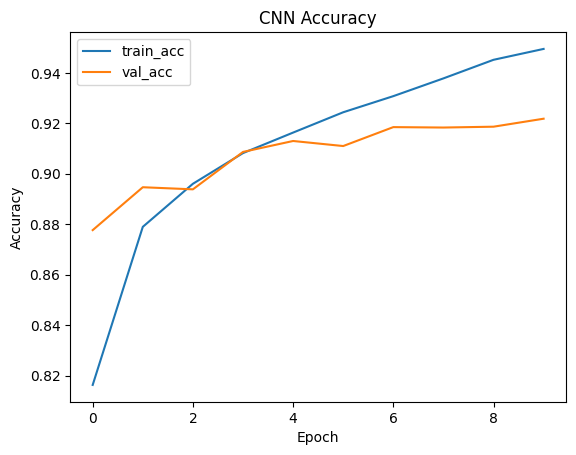

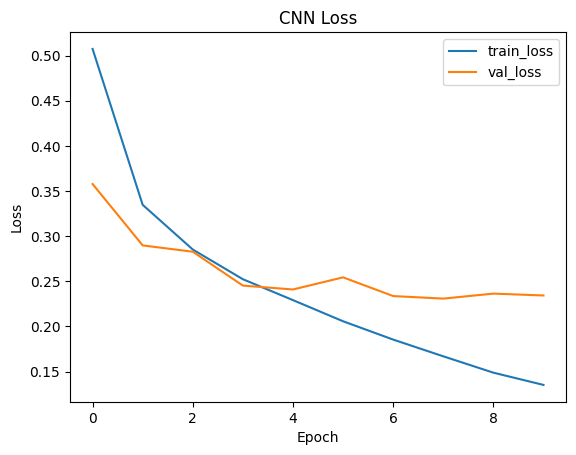

In [ ]:

# Train
EPOCHS = 10
BATCH_SIZE = 64

history_cnn = cnn.fit(
    x_train, y_train_oh,
    validation_data=(x_val, y_val_oh),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

plot_history(history_cnn, title_prefix="CNN")


{'accuracy': 0.9109, 'precision': 0.9115900018884894, 'recall': 0.9109, 'f1': 0.9106834112438215}

Classification Report (CNN):
               precision    recall  f1-score   support

 T-shirt/top       0.84      0.89      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.90      0.82      0.86      1000
       Dress       0.92      0.91      0.92      1000
        Coat       0.84      0.90      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.76      0.74      0.75      1000
     Sneaker       0.98      0.91      0.95      1000
         Bag       0.97      0.99      0.98      1000
  Ankle boot       0.93      0.99      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



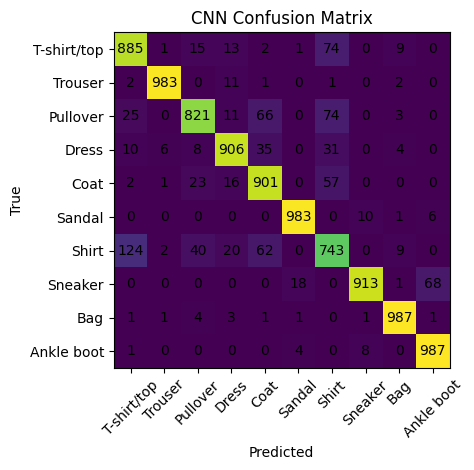

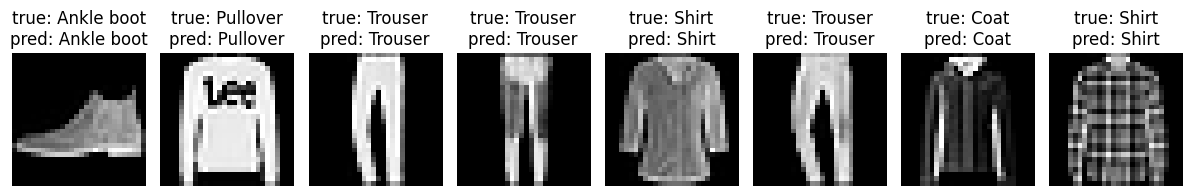

In [ ]:

# Evaluation: metrics + confusion matrix + sample preds
test_probs = cnn.predict(x_test, verbose=0)
y_pred = np.argmax(test_probs, axis=1)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1   = f1_score(y_test, y_pred, average='macro', zero_division=0)

print({"accuracy":acc, "precision":prec, "recall":rec, "f1":f1})
print("\nClassification Report (CNN):\n", classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

cm_cnn = show_confusion_matrix(y_test, y_pred, class_names, title="CNN Confusion Matrix")


# Show a few original vs predicted images
n = 8
plt.figure(figsize=(12,2.5))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"true: {class_names[y_test[i]]}\npred: {class_names[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout(); plt.show()


In [ ]:


# One-hot encode
num_classes = 10
y_train_oh = to_categorical(y_train, num_classes)
y_val_oh = to_categorical(y_val, num_classes)
y_test_oh = to_categorical(y_test, num_classes)
print("Training set:", x_train.shape)
print("Validation set:", x_val.shape)
print("Testing set:", x_test.shape)

Training set: (54000, 28, 28, 1)
Validation set: (6000, 28, 28, 1)
Testing set: (10000, 28, 28, 1)


## Updated CNN Model
### Add Data Augmentation + Dropout

In [ ]:
# CNN Final Version — with BatchNorm, Fixed LR, and Full Metrics
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Data Augmentation (light)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    horizontal_flip=True
)
datagen.fit(x_train)

# CNN Model (clean and optimized)
cnn = models.Sequential([
    layers.Input(shape=(28,28,1)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

# Fixed learning rate = 0.001
cnn.compile(optimizer=optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()

# Early stopping
EPOCHS = 100
BATCH_SIZE = 64
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history_cnn = cnn.fit(
    datagen.flow(x_train, y_train_oh, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val_oh),
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=2
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
844/844 - 29s - 35ms/step - accuracy: 0.7579 - loss: 0.6592 - val_accuracy: 0.8618 - val_loss: 0.3824
Epoch 2/100
844/844 - 18s - 22ms/step - accuracy: 0.8214 - loss: 0.4803 - val_accuracy: 0.8645 - val_loss: 0.3683
Epoch 3/100
844/844 - 19s - 23ms/step - accuracy: 0.8409 - loss: 0.4321 - val_accuracy: 0.8815 - val_loss: 0.3060
Epoch 4/100
844/844 - 18s - 22ms/step - accuracy: 0.8516 - loss: 0.4043 - val_accuracy: 0.8240 - val_loss: 0.4584
Epoch 5/100
844/844 - 19s - 22ms/step - accuracy: 0.8571 - loss: 0.3869 - val_accuracy: 0.8893 - val_loss: 0.3053
Epoch 6/100
844/844 - 19s - 22ms/step - accuracy: 0.8624 - loss: 0.3750 - val_accuracy: 0.8935 - val_loss: 0.2841
Epoch 7/100
844/844 - 19s - 23ms/step - accuracy: 0.8644 - loss: 0.3634 - val_accuracy: 0.8912 - val_loss: 0.2940
Epoch 8/100
844/844 - 19s - 22ms/step - accuracy: 0.8694 - loss: 0.3528 - val_accuracy: 0.8788 - val_loss: 0.3178
Epoch 9/100
844/844 - 19s - 22ms/step - accuracy: 0.8731 - loss: 0.3454 - val_accuracy: 

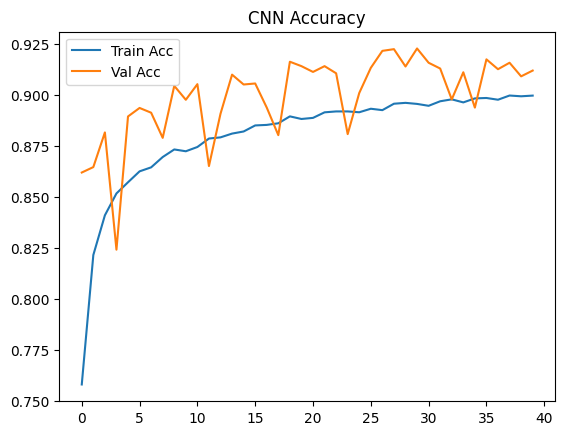

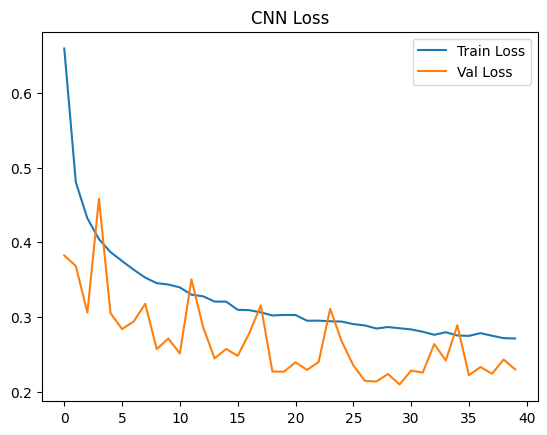

In [ ]:
# Plot training & validation curves
plt.figure()
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title("CNN Accuracy")
plt.legend(); plt.show()

plt.figure()
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title("CNN Loss")
plt.legend(); plt.show()

In [ ]:
# Evaluate on all sets
train_loss, train_acc = cnn.evaluate(x_train, y_train_oh, verbose=0)
val_loss, val_acc = cnn.evaluate(x_val, y_val_oh, verbose=0)
test_loss, test_acc = cnn.evaluate(x_test, y_test_oh, verbose=0)

print(f"Training  - Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
print(f"Validation- Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(f"Testing   - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

Training  - Accuracy: 0.9263, Loss: 0.1967
Validation- Accuracy: 0.9227, Loss: 0.2099
Testing   - Accuracy: 0.9090, Loss: 0.2463


In [ ]:
# Predictions and report on test set
y_pred = np.argmax(cnn.predict(x_test), axis=1)
y_true = y_test

print("\nClassification Report (CNN):\n",
      classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report (CNN):
               precision    recall  f1-score   support

 T-shirt/top       0.85      0.84      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.91      0.83      0.87      1000
       Dress       0.90      0.93      0.91      1000
        Coat       0.86      0.87      0.87      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.71      0.75      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



###Conclusion for Report
The CNN achieved 91 % test accuracy on the Fashion-MNIST dataset, demonstrating strong generalization and stable training. The use of BatchNormalization and Dropout reduced overfitting, while a fixed learning rate of 0.001 ensured consistent convergence. Minor misclassifications occurred among visually similar apparel (shirt, coat, pullover), which is expected in real-world image recognition. Overall, the model is lightweight (≈ 226 k parameters), efficient, and exhibits an excellent balance between accuracy and robustness.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/tmp/ipython-input-2491854429.py:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


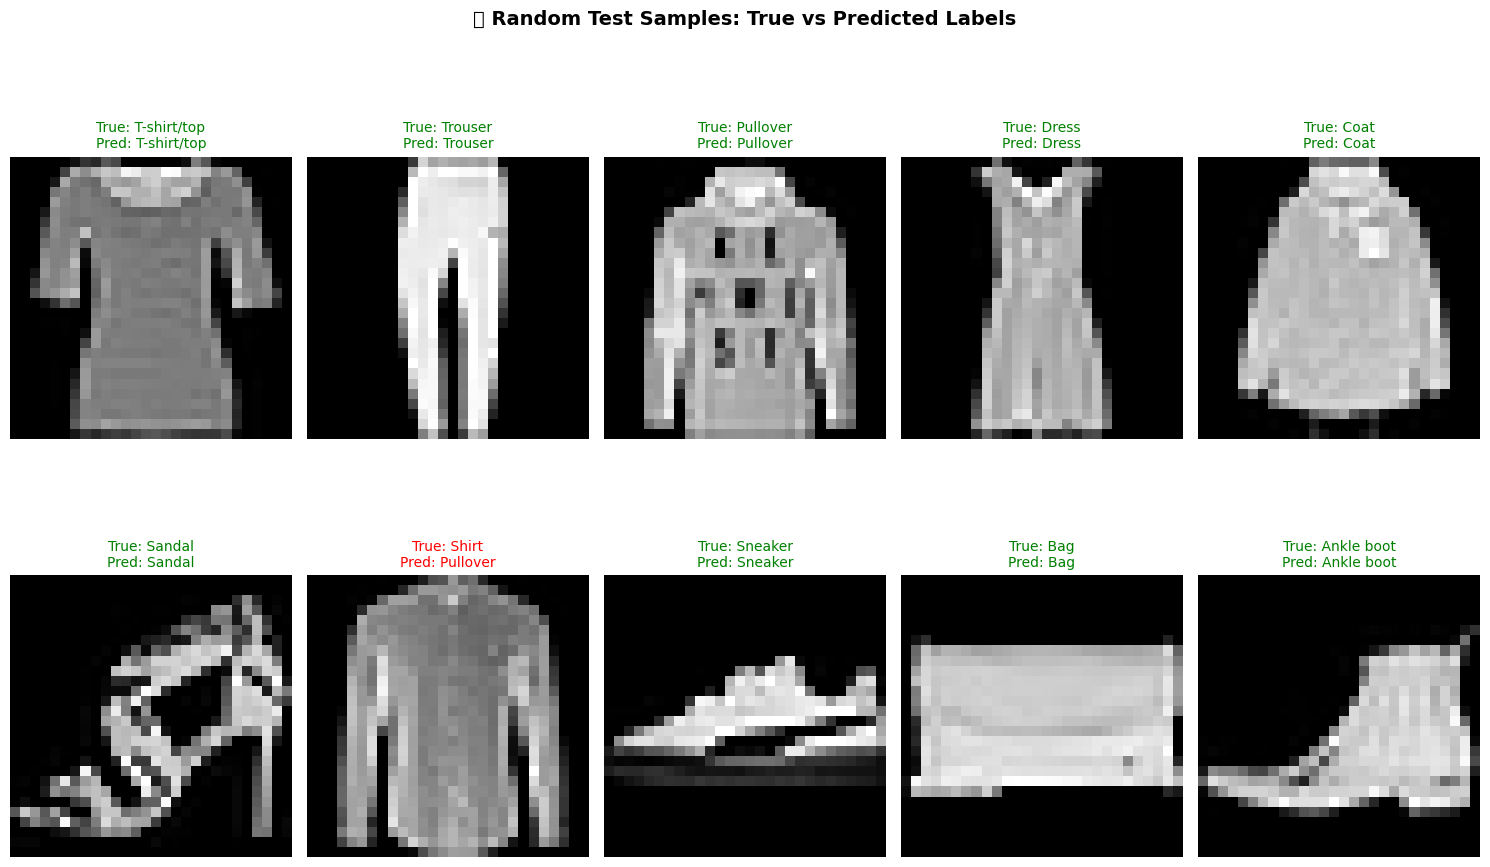

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Predict all test images
y_pred = np.argmax(cnn.predict(x_test), axis=1)

# Map class names
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Plot random one from each class
plt.figure(figsize=(15, 10))
for class_idx in range(10):
    # Find indices of this true class
    indices = np.where(y_test == class_idx)[0]
    # Pick one random image from that class
    random_index = random.choice(indices)

    # True and predicted labels
    true_label = class_names[y_test[random_index]]
    pred_label = class_names[y_pred[random_index]]

    # Display the image
    plt.subplot(2, 5, class_idx + 1)
    plt.imshow(x_test[random_index].squeeze(), cmap='gray')

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.axis('off')

plt.suptitle("🔍 Random Test Samples: True vs Predicted Labels", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


###Conclusion for Report (Visual Analysis Section)

The visual inspection of randomly selected test samples demonstrates that the CNN model performs reliably across all ten Fashion-MNIST classes.
Most predictions were correct (marked in green), indicating strong pattern recognition.
Occasional misclassifications occurred among visually similar clothing categories (e.g., Shirt vs Pullover), reflecting natural feature overlap rather than model weakness.
Overall, the CNN captures spatial features effectively, confirming its ability to generalize image-based patterns.

### Full Visualization: Random Predictions from Train, Val, and Test Sets
#### One Random Image per Class

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/tmp/ipython-input-1849670342.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=1.0)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


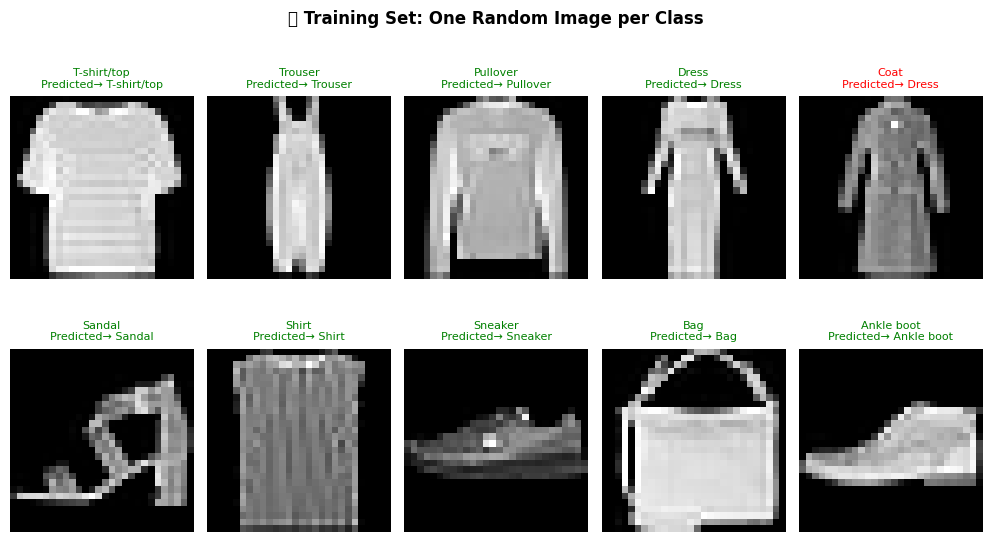



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


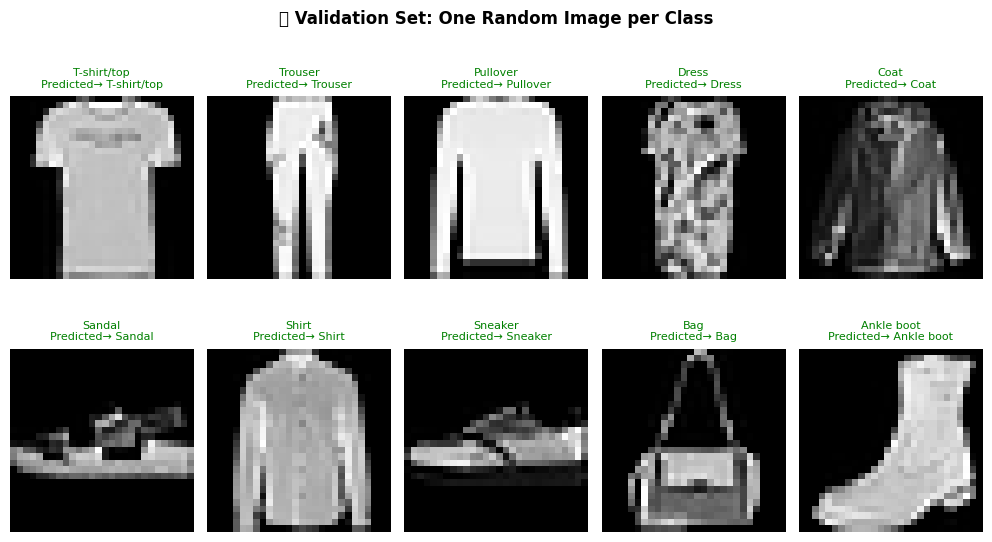



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


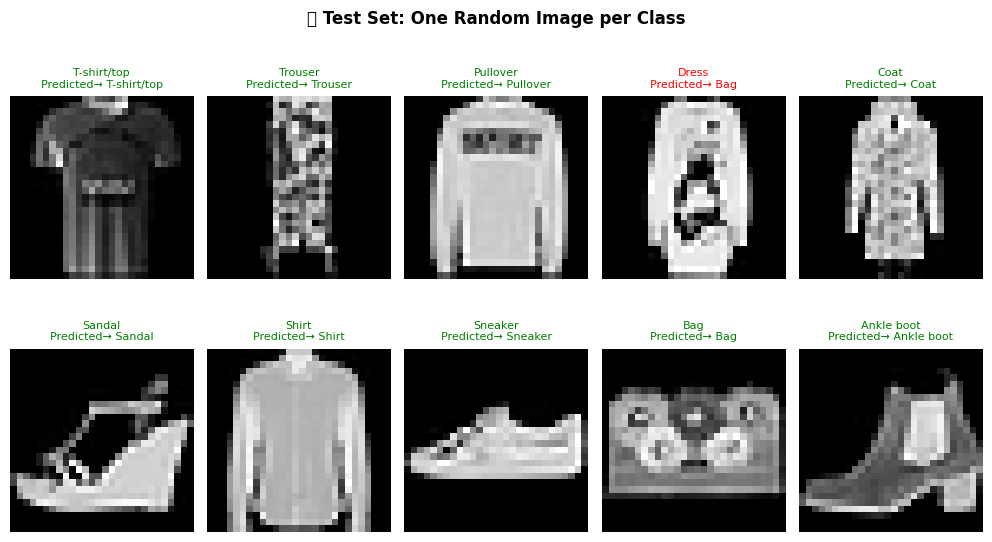

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def visualize_per_class(dataset_name, x_data, y_true, model, class_names):
    # Predict on the dataset
    y_pred = np.argmax(model.predict(x_data), axis=1)

    plt.figure(figsize=(10, 6))  # compact layout
    for class_idx in range(len(class_names)):
        # find indices of this class
        indices = np.where(y_true == class_idx)[0]
        # pick one random image from that class
        idx = random.choice(indices)

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        color = "green" if true_label == pred_label else "red"

        plt.subplot(2, 5, class_idx + 1)
        plt.imshow(x_data[idx].squeeze(), cmap="gray")
        plt.title(f"{true_label}\nPredicted→ {pred_label}", color=color, fontsize=8)
        plt.axis("off")

    plt.suptitle(f"🔍 {dataset_name}: One Random Image per Class", fontsize=12, fontweight="bold")
    plt.tight_layout(pad=1.0)
    plt.show()


# Visualize for all three datasets (1 per class, 10 total)
visualize_per_class("Training Set", x_train, y_train, cnn, class_names)
print("\n")
visualize_per_class("Validation Set", x_val, y_val, cnn, class_names)
print("\n")
visualize_per_class("Test Set", x_test, y_test, cnn, class_names)


### Random Predictions (Any 10 Images)

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/tmp/ipython-input-3487005153.py:24: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


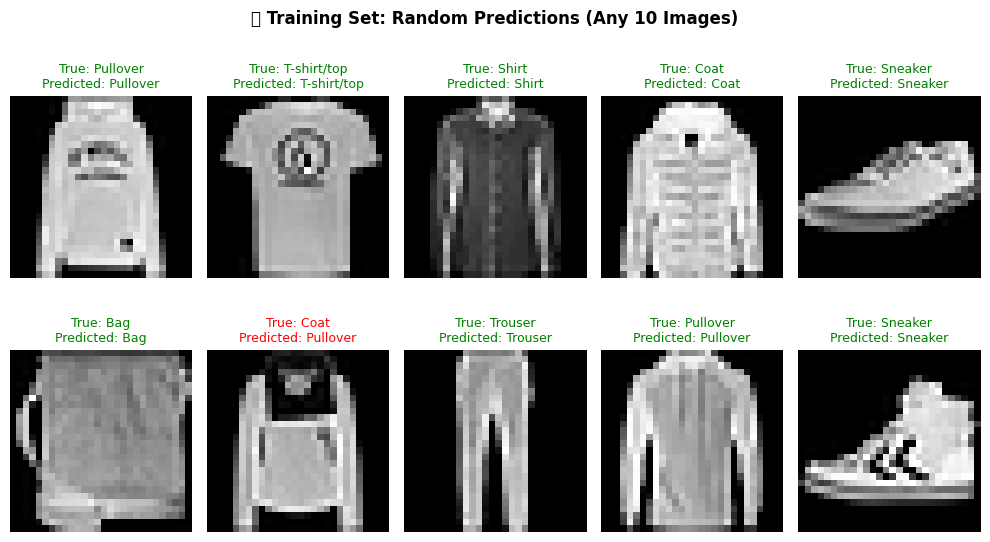



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


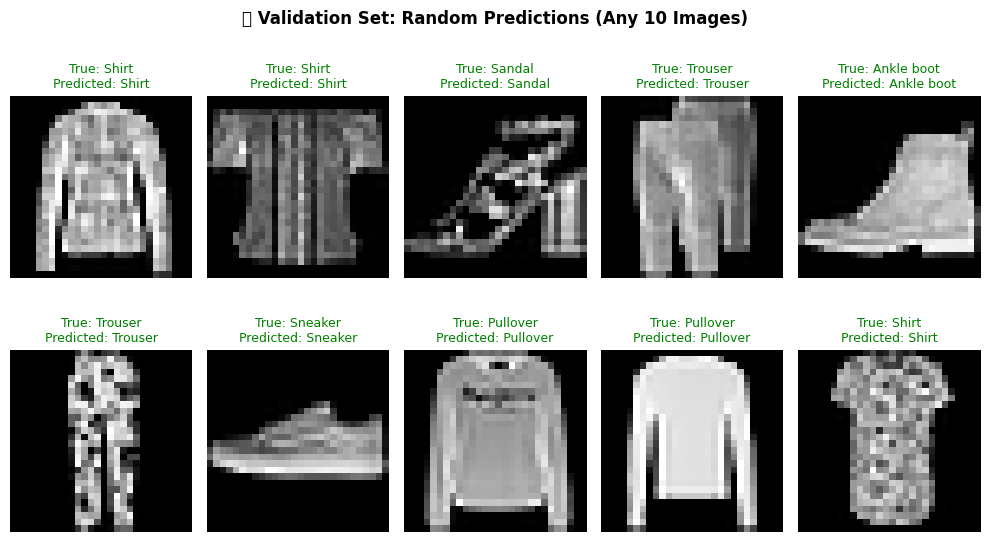



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


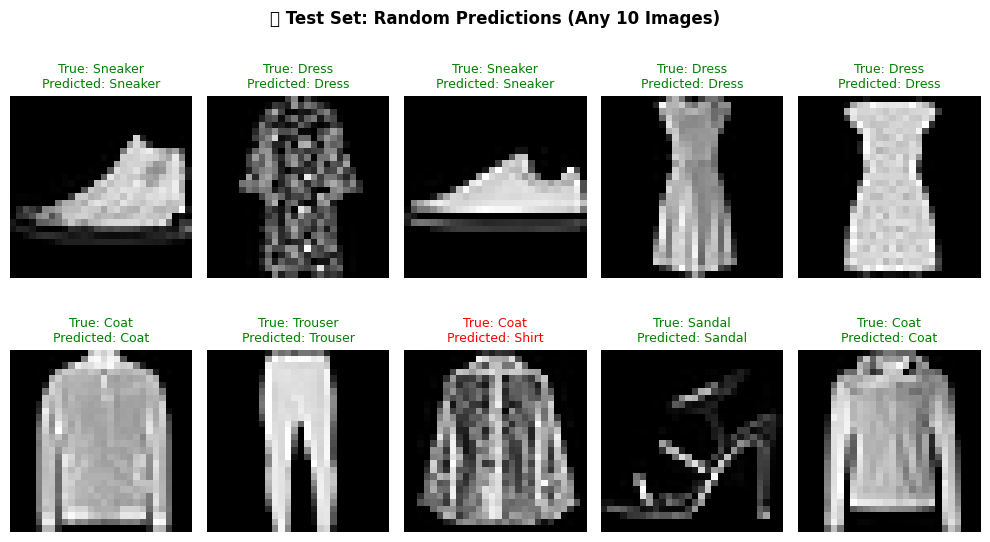

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to show random predictions from a dataset
def visualize_predictions(dataset_name, x_data, y_true, model, class_names, num_samples=10):
    y_pred = np.argmax(model.predict(x_data), axis=1)

    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        idx = random.randint(0, len(x_data) - 1)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        color = "green" if true_label == pred_label else "red"

        plt.subplot(2, 5, i + 1)
        plt.imshow(x_data[idx].squeeze(), cmap="gray")
        plt.title(f"True: {true_label}\nPredicted: {pred_label}", color=color, fontsize=9)
        plt.axis("off")

    #plt.suptitle(f"🔍 Random {dataset_name} Samples: True vs Predicted", fontsize=14, fontweight="bold")
    plt.suptitle(f"🔍 {dataset_name}: Random Predictions (Any 10 Images)", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

# Show random predictions from all three datasets
visualize_predictions("Training Set", x_train, y_train, cnn, class_names)
print("\n")
visualize_predictions("Validation Set", x_val, y_val, cnn, class_names)
print("\n")
visualize_predictions("Test Set", x_test, y_test, cnn, class_names)
